<a href="https://colab.research.google.com/github/meliy-meyada/Tensorflow-Deep-Learning-and-Artificial-Intelligence/blob/main/TF2_0_Stock_Returns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Tensorflow
!pip install -q tensorflow
import tensorflow as tf
print(tf.__version__)

2.8.2


In [2]:
# Additional imports

from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, Flatten, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [4]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [5]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [6]:
series = df['close'].values.reshape(-1, 1)

In [7]:
# Normalize the data
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [8]:
# Build the dataset

T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T X D
Y = np.array(Y)
N = len(X)
print("X.shape ", X.shape, "Y.shape ", Y.shape)

X.shape  (1249, 10, 1) Y.shape  (1249,)


In [9]:
# Autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.1),
)

# Train RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:]),

)

Epoch 1/80


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 3s 32ms/step - loss: 0.2833 - val_loss: 0.2004
Epoch 2/80
20/20 [==============================] - 0s 8ms/step - loss: 0.0206 - val_loss: 0.0337
Epoch 3/80
20/20 [==============================] - 0s 8ms/step - loss: 0.0074 - val_loss: 0.0296
Epoch 4/80
20/20 [==============================] - 0s 8ms/step - loss: 0.0063 - val_loss: 0.0309
Epoch 5/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0069 - val_loss: 0.0268
Epoch 6/80
20/20 [==============================] - 0s 8ms/step - loss: 0.0059 - val_loss: 0.0278
Epoch 7/80
20/20 [==============================] - 0s 9ms/step - loss: 0.0063 - val_loss: 0.0266
Epoch 8/80
20/20 [==============================] - 0s 10ms/step - loss: 0.0059 - val_loss: 0.0306
Epoch 9/80
20/20 [==============================] - 0s 10ms/step - loss: 0.0072 - val_loss: 0.0491
Epoch 10/80
20/20 [==============================] - 0s 8ms/step - loss: 0.0069 - val_loss: 0.0297
Epoch 11/80
20/20 [========

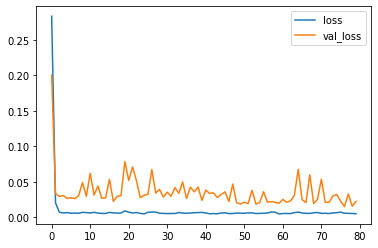

In [10]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1249, 1)


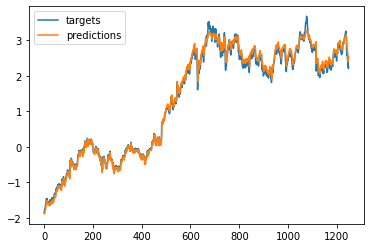

In [11]:
# One-step forecast using true target
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

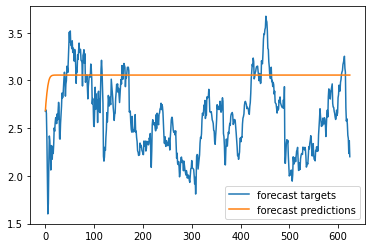

In [12]:
# Multi-step forecast

validation_target = Y[-N//2:]
validation_predictions = []

# Last train input
last_x = X[-N//2] # 1-D array of lenght T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # Update the predictions list
  validation_predictions.append(p)

  # Make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast targets')
plt.plot(validation_predictions, label='forecast predictions')
plt.legend()

In [13]:
# Calculate returns by first shifting thr data
df['PrevClose'] = df['close'].shift(1) # Move everything up 1

# close / prev close
# X[2] X[1]
# X[3] X[2]
# X[4] X[3]
# ...
# X[t] X[t-1]

In [14]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [15]:
# Then the returns is
# (X[t] - X[t-1]) / X[t-1]
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

In [16]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


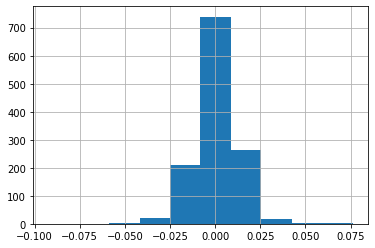

In [17]:
df['Return'].hist()

In [18]:
series = df['Return'].values[1:].reshape(-1, 1)

# Normalize the data
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [19]:
# Build the dataset

T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T X D
Y = np.array(Y)
N = len(X)
print("X.shape ", X.shape, "Y.shape ", Y.shape)

X.shape  (1248, 10, 1) Y.shape  (1248,)


In [20]:
# Autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.01),
)

# Train RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:]),

)

Epoch 1/80


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 3s 46ms/step - loss: 0.9898 - val_loss: 1.1609
Epoch 2/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9888 - val_loss: 1.1398
Epoch 3/80
20/20 [==============================] - 0s 9ms/step - loss: 0.9841 - val_loss: 1.1495
Epoch 4/80
20/20 [==============================] - 0s 8ms/step - loss: 0.9845 - val_loss: 1.1555
Epoch 5/80
20/20 [==============================] - 0s 9ms/step - loss: 0.9829 - val_loss: 1.1438
Epoch 6/80
20/20 [==============================] - 0s 8ms/step - loss: 0.9867 - val_loss: 1.1538
Epoch 7/80
20/20 [==============================] - 0s 8ms/step - loss: 0.9840 - val_loss: 1.1475
Epoch 8/80
20/20 [==============================] - 0s 8ms/step - loss: 0.9796 - val_loss: 1.1482
Epoch 9/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9864 - val_loss: 1.1450
Epoch 10/80
20/20 [==============================] - 0s 9ms/step - loss: 0.9801 - val_loss: 1.1464
Epoch 11/80
20/20 [========

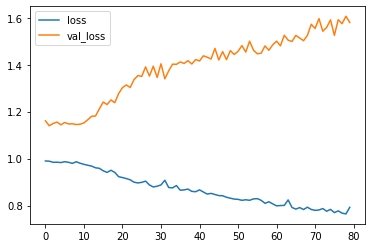

In [21]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1248, 1)


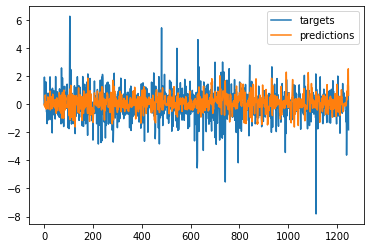

In [22]:
# One-step forecast using true target
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

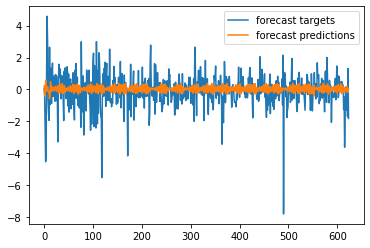

In [23]:
# Multi-step forecast

validation_target = Y[-N//2:]
validation_predictions = []

# Last train input
last_x = X[-N//2] # 1-D array of lenght T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # Update the predictions list
  validation_predictions.append(p)

  # Make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast targets')
plt.plot(validation_predictions, label='forecast predictions')
plt.legend()

In [24]:
# Trun the full data into numpy arrays

input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

In [25]:
# Make the actual data which will go into neural network
T = 10 # The number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T 

In [26]:
# Normalize the inputs
Ntrain = len(input_data)* 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T])
input_data = scaler.transform(input_data)

In [27]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [28]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [29]:
# Make the RNN
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=0.001),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [30]:
# Train the RNN
r = model.fit(
    X_train, Y_train,
    batch_size=32,
    epochs=300,
    validation_data=(X_test, Y_test),
)

Epoch 1/300
27/27 [==============================] - 3s 24ms/step - loss: 0.6962 - accuracy: 0.4899 - val_loss: 0.6934 - val_accuracy: 0.4732
Epoch 2/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6936 - accuracy: 0.5197 - val_loss: 0.6937 - val_accuracy: 0.4976
Epoch 3/300
27/27 [==============================] - 0s 8ms/step - loss: 0.6924 - accuracy: 0.5030 - val_loss: 0.6957 - val_accuracy: 0.4902
Epoch 4/300
27/27 [==============================] - 0s 9ms/step - loss: 0.6915 - accuracy: 0.5256 - val_loss: 0.6925 - val_accuracy: 0.5049
Epoch 5/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6939 - accuracy: 0.4934 - val_loss: 0.6902 - val_accuracy: 0.5098
Epoch 6/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6900 - accuracy: 0.5256 - val_loss: 0.7027 - val_accuracy: 0.4902
Epoch 7/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6908 - accuracy: 0.5256 - val_loss: 0.6931 - val_accuracy: 0.4951
Epoch 8/300


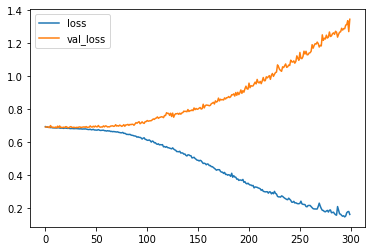

In [31]:
# Plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

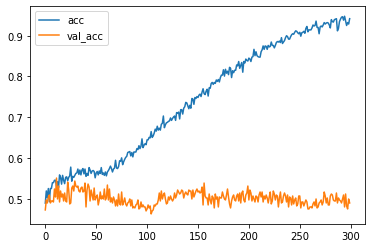

In [32]:
# PLot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()